In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.utils.data as data_utils
import os
import torchvision.utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib import image
from matplotlib import pyplot
import time

In [ ]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  train_transform=transforms.Compose([transforms.Resize(inp_size), transforms.RandomVerticalFlip(), 
                                transforms.CenterCrop(inp_size[0]), transforms.ToTensor(), normalize])
  val_transform = transforms.Compose([transforms.Resize(inp_size), transforms.ToTensor(), normalize])
  train_data = datasets.ImageFolder(root=path+"/train", transform=train_transform)
  val_data = datasets.ImageFolder(root=path+"/val",transform=val_transform)
  test_data = datasets.ImageFolder(root=path+"/test",transform=val_transform)
  print(val_data)
  # test_split = round((1-train_split-val_split), 2)
  # print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  data_length = len(val_data)
  # The no. of images in each split of train, val and test
  train_size = int(0.3*data_length)
  val_size = int(0.6*data_length)
  test_size = data_length - val_size - train_size
  val_data, _, _ = td.random_split(val_data, [train_size, val_size, 
                                                    test_size])
  
  print(len(val_data))
  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader,test_loader

In [ ]:
# Initialize the data loaders through the image_preprocess function
path = "/content/drive/MyDrive/AI Final Project/fourClass"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224, 224))

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/MyDrive/AI Final Project/fourClass/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
600


In [ ]:
# Loader data plotted for visualizaion
def plot_data_loader(loader, grid):
  fig, axes = plt.subplots(nrows=grid[0], ncols=grid[1], figsize=(6,6))
  dataiter = iter(loader)
  for i in range(grid[0]):
    for j in range(grid[1]):
      images, _ = dataiter.next()
      axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

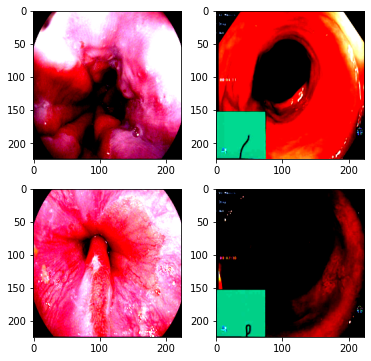

In [ ]:
plot_data_loader(train_loader, [2,2])

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=20):
    start = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))

    best_model_weights = model.state_dict()
    best_accuracy = 0

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):
      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)

        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model_weights = model.state_dict()

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    model.load_state_dict(best_model_weights)
    return model, train_accuracy_list, val_accuracy_list, best_accuracy

In [ ]:
# Model definition and initialization
Dense_net = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained= False)
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 8)
optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
dense_net_4, denseNet_training_accuracy_list_4, denseNet_val_accuracy_list_4, best_accuracy_4 = train_model(Dense_net, train_loader, val_loader, optimizer, loss, epochs=20)

Device: cuda:0
Epoch [1/20], Train_Loss: 1.9690, Train_Accuracy: 34.38%  Val_Loss: 1.2678, Val_Accuracy: 87.50%
Epoch [1/20], Train_Loss: 1.1877, Train_Accuracy: 75.00%  Val_Loss: 0.7758, Val_Accuracy: 79.17%
Epoch [1/20], Train_Loss: 0.6835, Train_Accuracy: 90.62%  Val_Loss: 0.6774, Val_Accuracy: 83.33%
Epoch [1/20], Train_Loss: 0.4438, Train_Accuracy: 87.50%  Val_Loss: 0.3938, Val_Accuracy: 95.83%
Epoch [1/20], Train_Loss: 0.4898, Train_Accuracy: 78.12%  Val_Loss: 0.6068, Val_Accuracy: 75.00%
Epoch [1/20], Train_Loss: 0.5571, Train_Accuracy: 78.12%  Val_Loss: 0.4833, Val_Accuracy: 79.17%
Epoch [1/20], Train_Loss: 0.2544, Train_Accuracy: 90.62%  Val_Loss: 0.4615, Val_Accuracy: 83.33%
Epoch [1/20], Train_Loss: 0.3426, Train_Accuracy: 90.62%  Val_Loss: 0.4846, Val_Accuracy: 87.50%
Epoch [1/20], Train_Loss: 0.4564, Train_Accuracy: 87.50%  Val_Loss: 0.7196, Val_Accuracy: 66.67%
Epoch [1/20], Train_Loss: 0.3151, Train_Accuracy: 84.38%  Val_Loss: 0.5267, Val_Accuracy: 75.00%
Epoch [1/20], T

In [ ]:
denseNet_4 = {'model': dense_net_4,
               'training_accuracy_list': denseNet_training_accuracy_list_4,
               'val_accuracy_list':   denseNet_val_accuracy_list_4,
              'state_dict': dense_net_4.state_dict()}

In [ ]:
torch.save(denseNet_4, 'denseNet_tl.pth')

In [ ]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 6, num=6)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%234==0):
            accuracy.append(sum/234)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy, val_accuracy = accuracyForEachEpoch(training_accuracy_list), accuracyForEachEpoch(val_accuracy_list)

In [ ]:
train_val_comparison(train_accuracy, val_accuracy, len(train_loader))

In [ ]:
def evaluate_accuracy(model, test_loader):
  model.eval() 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model2 = model.to(device)
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model2(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))
      
  return total, (correct / total) * 100